<a href="https://colab.research.google.com/github/oktaviacitra/cv-course-in-graduate-school/blob/main/3Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

origin_path = "/content/drive"
drive.mount(origin_path)
folder_path = origin_path + "/MyDrive/Learning Journey/Viskom/"

Mounted at /content/drive


# Template Matching

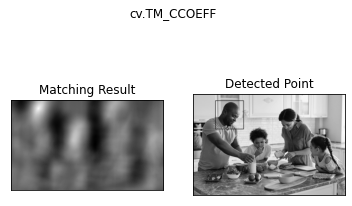

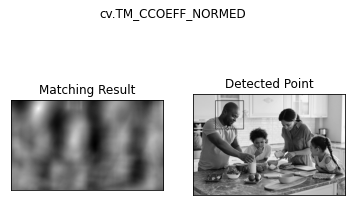

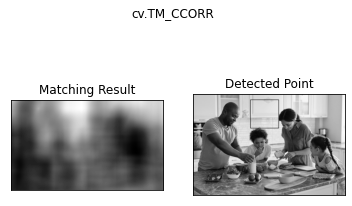

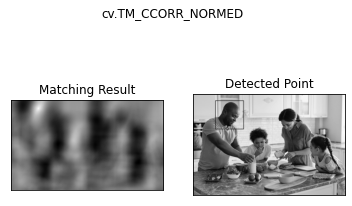

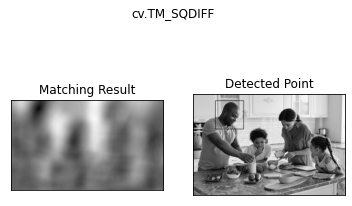

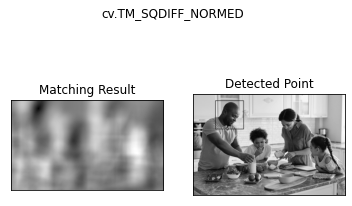

In [34]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread(folder_path + "family.jpg",0)
img2 = img.copy()
template = cv.imread(folder_path + "father.jpg",0)
w, h = template.shape[::-1]
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
  img = img2.copy()
  method = eval(meth)
  res = cv.matchTemplate(img,template,method)
  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
  if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
      top_left = min_loc
  else:
      top_left = max_loc
  bottom_right = (top_left[0] + w, top_left[1] + h)
  cv.rectangle(img,top_left, bottom_right, (0, 255, 200), 2)
  plt.subplot(121),plt.imshow(res,cmap = 'gray')
  plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(img,cmap = 'gray')
  plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
  plt.suptitle(meth)
  plt.show()

# Fruit Maturity

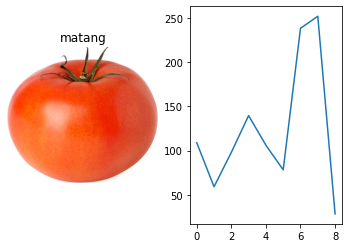

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread(folder_path + "red-tomato.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
B, G, R = cv2.split(image)

histogram_quantization = np.zeros(9)
histogram_quantization[0] = np.mean(R)
histogram_quantization[1] = np.median(R)
histogram_quantization[2] = np.std(R)
histogram_quantization[3] = np.mean(G)
histogram_quantization[4] = np.median(G)
histogram_quantization[5] = np.std(G)
histogram_quantization[6] = np.mean(B)
histogram_quantization[7] = np.median(B)
histogram_quantization[8] = np.std(B)

result = ""
if histogram_quantization[2] > 42.1 and histogram_quantization[4] > 186.:
  result = "belum matang"
elif histogram_quantization[5] > 55. and histogram_quantization[7] > 140.9:
  result = "matang"
else :
  result = "setengah matang"

plt.subplot(121)
plt.axis('off')
plt.title(result)
plt.imshow(image)
plt.subplot(122)
plt.plot(histogram_quantization)
plt.show()

# Filter Bank

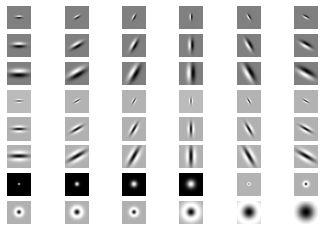

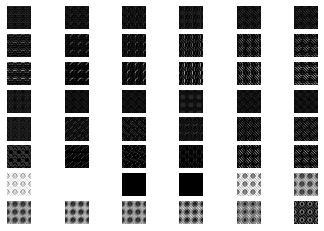

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

def gaussian1d(sigma, mean, x, ord):
  x = np.array(x)
  x_ = x - mean
  var = sigma**2

  # Gaussian Function
  g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
  
  if ord == 0:
      g = g1
      return g
  elif ord == 1:
      g = -g1*((x_)/(var))
      return g
  else:
      g = g1*(((x_*x_) - var)/(var**2))
      return g

def gaussian2d(sup, scales):
  var = scales * scales
  shape = (sup,sup)
  n,m = [(i - 1)/2 for i in shape]
  x,y = np.ogrid[-m:m+1,-n:n+1]
  g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
  return g

def log2d(sup, scales):
  var = scales * scales
  shape = (sup,sup)
  n,m = [(i - 1)/2 for i in shape]
  x,y = np.ogrid[-m:m+1,-n:n+1]
  g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
  h = g*((x*x + y*y) - var)/(var**2)
  return h

def makefilter(scale, phasex, phasey, pts, sup):
  gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
  gy = gaussian1d(scale,   0, pts[1,...], phasey)
  image = gx*gy
  image = np.reshape(image,(sup,sup))
  return image

def makeLMfilters():
  sup     = 49
  scalex  = np.sqrt(2) * np.array([1,2,3])
  norient = 6
  nrotinv = 12

  nbar  = len(scalex)*norient
  nedge = len(scalex)*norient
  nf    = nbar+nedge+nrotinv
  F     = np.zeros([sup,sup,nf])
  hsup  = (sup - 1)/2

  x = [np.arange(-hsup,hsup+1)]
  y = [np.arange(-hsup,hsup+1)]

  [x,y] = np.meshgrid(x,y)

  orgpts = [x.flatten(), y.flatten()]
  orgpts = np.array(orgpts)
  
  count = 0
  for scale in range(len(scalex)):
      for orient in range(norient):
          angle = (np.pi * orient)/norient
          c = np.cos(angle)
          s = np.sin(angle)
          rotpts = [[c+0,-s+0],[s+0,c+0]]
          rotpts = np.array(rotpts)
          rotpts = np.dot(rotpts,orgpts)
          F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
          F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
          count = count + 1
          
  count = nbar+nedge
  scales = np.sqrt(2) * np.array([1,2,3,4])
  
  for i in range(len(scales)):
      F[:,:,count]   = gaussian2d(sup, scales[i])
      count = count + 1
      
  for i in range(len(scales)):
      F[:,:,count] = log2d(sup, scales[i])
      count = count + 1
      
  for i in range(len(scales)):
      F[:,:,count] = log2d(sup, 3*scales[i])
      count = count + 1
      
  return F


F = makeLMfilters()
image = cv2.imread(folder_path + "batik.jpg", 0)

for i in np.arange(48):
  kernel = F[:, :, i]
  image_result = cv2.filter2D(image, -1, kernel)
  plt.figure(1)
  plt.subplot(8, 6, i+1)
  plt.axis('off')
  plt.imshow(kernel, cmap='gray')
  plt.figure(2)
  plt.subplot(8, 6, i+1)
  plt.axis('off')
  plt.imshow(image_result, cmap='gray')
plt.show()
